<font size='200' style='font-family:Georgia' color='midnightblue'>APS 3</font> 


## <font style='font-family:Georgia' color='teal'> Estudo de uma treliça plana</font> 


####  <font style='font-family:Georgia' color='darkturquoise'> André Tavernaro || Antonio Fuzyi || Gabriela Mitu || Gabriella Cukier</font> 

### Importando bibliotecas e valores

In [364]:
from funcoesTermosol import *
import numpy as np
import math
import tqdm

### Representação da estrutura

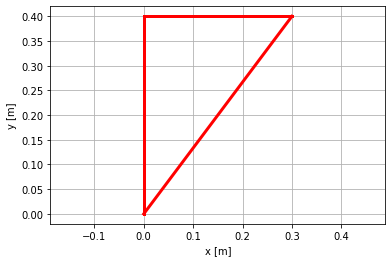

In [365]:
entrada = "trelica_sentido.xlsx"

[nn,N,nm,Inc,nc,F,nr,R] = importa(entrada)

plota(N, Inc)
# geraSaida()

### Informações sobre a treliça

* nn: número de nós
* N: Matriz dos nós
* nm: número de membros
* Inc: Matriz de incidência. Colunas:
    1. Nó 1
    2. Nó 2
    3. E
    4. A
* nc: número de cargas
* F: forças (Vetor carregamento)
* nr: número de restrições
* R: Restrições (Vetor com os graus de liberdade)

In [366]:
# Comprimento 
L = 5
#numero de nodes
n = 8

In [367]:
nodes = np.zeros((2, n))
print(nodes)

[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]


### Gerando a matriz de conectividade transposta

In [368]:
C = []
for i in range(nm):
        C_i = nn*[0]

        no_1 = int(Inc[i, 0])
        no_2 = int(Inc[i, 1])

        C_i[no_1-1] = -1
        C_i[no_2-1] = 1
        C.append(C_i) 

C_t = np.array(C).T
C_t

array([[-1,  0,  1],
       [ 1, -1,  0],
       [ 0,  1, -1]])

### Matriz dos membros (M)

In [369]:
M = np.matmul(N, C_t)
print(M)

[[ 0.   0.3 -0.3]
 [ 0.4  0.  -0.4]]


### Obtendo Se, Ke e Kg

In [370]:
len_linhas_M = len(M)
len_linhas_C = len(C_t)
Kg = np.zeros((nn*2, nn*2))
for i in range(0, nm):
    E = Inc[i,2]
    A = Inc[i,3]
    
    n1 = Inc[i,0]
    n2 = Inc[i,1]
    
    x1 = N[0][int(Inc[:,0][i])-1]
    y1 = N[1][int(Inc[:,0][i])-1]
    x2 = N[0][int(Inc[:,1][i])-1]
    y2 = N[1][int(Inc[:,1][i])-1]    
    
    L = math.sqrt(((x1-x2)**2+(y1-y2)**2))
    
    const = E*A/L
    
    M_aux = M[:,i]
    M_aux.shape = [len_linhas_M, 1]
    M_aux2 = np.transpose(M_aux)
    Se = (const * np.matmul(M_aux, M_aux2)) / (np.linalg.norm(M[:,i])**2)

    C_aux = C_t[:,i]
    C_aux.shape = [len_linhas_C, 1]
    C_aux2 = np.transpose(C_aux)
    
    multi_C_aux = np.matmul(C_aux, C_aux2)
    Ke = np.kron(multi_C_aux, Se)
    Kg += Ke
# print(Se)
print(Kg)

[[ 3.0240e+07  4.0320e+07  0.0000e+00  0.0000e+00 -3.0240e+07 -4.0320e+07]
 [ 4.0320e+07  1.5876e+08  0.0000e+00 -1.0500e+08 -4.0320e+07 -5.3760e+07]
 [ 0.0000e+00  0.0000e+00  1.4000e+08  0.0000e+00 -1.4000e+08  0.0000e+00]
 [ 0.0000e+00 -1.0500e+08  0.0000e+00  1.0500e+08  0.0000e+00  0.0000e+00]
 [-3.0240e+07 -4.0320e+07 -1.4000e+08  0.0000e+00  1.7024e+08  4.0320e+07]
 [-4.0320e+07 -5.3760e+07  0.0000e+00  0.0000e+00  4.0320e+07  5.3760e+07]]


### Deslocamento nodal

Aplicando as condições de contorno para a matriz das forças:

In [371]:
F_c = np.delete(F, R.astype(int))
F_c


array([   0.,  150., -100.])

Aplicando as condições de contorno para a matriz da rigidez:

In [372]:
Kg_c = np.delete(Kg, R.astype(int),0)
Kg_c = np.delete(Kg_c, R.astype(int), 1)
Kg_c

array([[ 1.5876e+08, -4.0320e+07, -5.3760e+07],
       [-4.0320e+07,  1.7024e+08,  4.0320e+07],
       [-5.3760e+07,  4.0320e+07,  5.3760e+07]])

In [373]:
def jacobi(k,F,ite,tol):
    #inicializando X com 
    x = np.zeros(k.shape[0])

    # Cria um vetor com os elementos da diagonal de k                       
    diagonal = np.diag(k)
    # Subtrai a diagonal de K
    k_d = k - np.diagflat(diagonal)
    # loop até chegar abaixo da tolerância ou passar do número máximo de iterações
    for i in range(ite):
        x2 = (F - np.matmul(k_d,x)) / diagonal
        error =  max(abs((x2 - x)/x2) )
        if error < tol:
            print(f"Erro máximo: {error}")
            print(f"Convergiu na iteração: {i}")
            return x2
        
        x = x2
    return x

In [374]:
def gauss_seidel(A, b, ite, tol):
    x = np.zeros_like(b, dtype=np.double)
    
    #Iterate
    for k in range(ite):
        
        x_old  = x.copy()
        
        #Loop over rows
        for i in range(A.shape[0]):
            x[i] = (b[i] - np.dot(A[i,:i], x[:i]) - np.dot(A[i,(i+1):], x_old[(i+1):])) / A[i ,i]
            
        #Stop condition 
        if np.linalg.norm(x - x_old, ord=np.inf) / np.linalg.norm(x, ord=np.inf) < tol:
            break
            
    return x

In [375]:
u_jacobi = jacobi(Kg_c, F_c, 100, 1e-5)

Erro máximo: 8.929098735332758e-06
Convergiu na iteração: 59
<ipython-input-373-262c35adf621>:12: RuntimeWarning: invalid value encountered in true_divide
  error =  max(abs((x2 - x)/x2) )


In [376]:
u_jacobi

array([-9.52384854e-07,  1.60714601e-06, -4.01784975e-06])

In [377]:
u_gauss = gauss_seidel(Kg_c, F_c, 100, 1e-5)

In [378]:
u_gauss

array([-9.52374559e-07,  1.60713664e-06, -4.01784609e-06])

Deslocamentos nodais

In [379]:
U_ar = np.linalg.solve(Kg_c, F_c)
U_ar

array([-9.52380952e-07,  1.60714286e-06, -4.01785714e-06])

Ajustando o tamanho da matriz

In [380]:
u_jacobi_ajustado = np.zeros((nn*2,1))
i = 0
for e in range(len(u_jacobi_ajustado)):
    if e not in R:
        u_jacobi_ajustado[e] += u_jacobi[i]
        i += 1
u_jacobi_ajustado

array([[ 0.00000000e+00],
       [-9.52384854e-07],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 1.60714601e-06],
       [-4.01784975e-06]])

In [381]:
u_gauss_ajustado = np.zeros((nn*2,1))
i = 0
for e in range(len(u_gauss_ajustado)):
    if e not in R:
        u_gauss_ajustado[e] += u_gauss[i]
        i += 1
u_gauss_ajustado

array([[ 0.00000000e+00],
       [-9.52374559e-07],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 1.60713664e-06],
       [-4.01784609e-06]])

In [382]:
u = np.zeros((nn*2,1))
i = 0
for e in range(len(u)):
    if e not in R:
        u[e] += U_ar[i]
        i += 1
u

array([[ 0.00000000e+00],
       [-9.52380952e-07],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 1.60714286e-06],
       [-4.01785714e-06]])

### Reações de apoio

In [383]:
P = np.matmul(Kg,u)
P

array([[  75.],
       [   0.],
       [-225.],
       [ 100.],
       [ 150.],
       [-100.]])

In [384]:
P_r = np.zeros((nr,1))
for i in range(nr):  
    index = int(R[i])
    P_r[i] = P[index]    
P_r

array([[  75.],
       [-225.],
       [ 100.]])

### Deformações, Tenões e Forças internas

In [385]:
deformacoes=[]
tensoes=[]
forcas=[]
len_linhas_M = len(M)
len_linhas_C = len(C_t)
Kg = np.zeros((nn*2, nn*2))
for i in range(0, nm):
    E = Inc[i,2]
    A = Inc[i,3]
    
    n1 = Inc[i,0]
    n2 = Inc[i,1]
    
    x1 = N[0][int(Inc[:,0][i])-1]
    y1 = N[1][int(Inc[:,0][i])-1]
    x2 = N[0][int(Inc[:,1][i])-1]
    y2 = N[1][int(Inc[:,1][i])-1]    
    
    L = math.sqrt(((x1-x2)**2+(y1-y2)**2))
    
    const = E*A/L
    
    M_aux = M[:,i]
    M_aux.shape = [len_linhas_M, 1]
    M_aux2 = np.transpose(M_aux)
    Se = (const * np.matmul(M_aux, M_aux2)) / (np.linalg.norm(M[:,i])**2)

    C_aux = C_t[:,i]
    C_aux.shape = [len_linhas_C, 1]
    C_aux2 = np.transpose(C_aux)
    
    multi_C_aux = np.matmul(C_aux, C_aux2)
    Ke = np.kron(multi_C_aux, Se)
    Kg += Ke
    
    matriz = [
        u[(int(Inc[i, 0])-1)*2], 
        u[(int(Inc[i, 0])-1)*2 +1], 
        u[(int(Inc[i, 1])-1)*2], 
        u[int(Inc[i, 1]-1)*2 +1]
    ]
        
    s = (y2-y1)/L
    c = (x2-x1)/L
    
    C = [-c, -s, c, s]
    
    deformacao = (1/L) * np.matmul(C, matriz)
    tensao = deformacao*E
    forca=tensao*A
    
    deformacoes.append(deformacao)
    tensoes.append(tensao)
    forcas.append(forca)

# print(Se)
print(Kg)

[[ 3.0240e+07  4.0320e+07  0.0000e+00  0.0000e+00 -3.0240e+07 -4.0320e+07]
 [ 4.0320e+07  1.5876e+08  0.0000e+00 -1.0500e+08 -4.0320e+07 -5.3760e+07]
 [ 0.0000e+00  0.0000e+00  1.4000e+08  0.0000e+00 -1.4000e+08  0.0000e+00]
 [ 0.0000e+00 -1.0500e+08  0.0000e+00  1.0500e+08  0.0000e+00  0.0000e+00]
 [-3.0240e+07 -4.0320e+07 -1.4000e+08  0.0000e+00  1.7024e+08  4.0320e+07]
 [-4.0320e+07 -5.3760e+07  0.0000e+00  0.0000e+00  4.0320e+07  5.3760e+07]]


In [386]:
deformacoes=[]
tensoes=[]
forcas=[]
for i in range (nm):
        
    matriz = [
            u[(int(Inc[i, 0])-1)*2], 
            u[(int(Inc[i, 0])-1)*2 +1], 
            u[(int(Inc[i, 1])-1)*2], 
            u[int(Inc[i, 1]-1)*2 +1]
    ]
    
    x1 = N[0][int(Inc[:,0][i])-1]
    y1 = N[1][int(Inc[:,0][i])-1]
    x2 = N[0][int(Inc[:,1][i])-1]
    y2 = N[1][int(Inc[:,1][i])-1]    
    
    L = math.sqrt(((x1-x2)**2+(y1-y2)**2))  
    
    E =  Inc[i, 2]
    A = Inc[i,3]
    const = E*A/L
    
    s = (y2-y1)/L
    c = (x2-x1)/L
    
    C = [-c, -s, c, s]

    deformacao = (1/L) * np.matmul(C, matriz)
    tensao = deformacao*E
    forca=tensao*A
    
    deformacoes.append(deformacao)
    tensoes.append(tensao)
    forcas.append(forca)



In [387]:
deformacoes

[array([2.38095238e-06]), array([5.35714286e-06]), array([-2.97619048e-06])]

In [388]:
tensoes

[array([500000.]), array([1125000.]), array([-625000.])]

In [389]:
forcas

[array([100.]), array([225.]), array([-125.])]

In [390]:
geraSaida("geral", P_r, u, deformacoes, forcas, tensoes)

In [391]:
geraSaida("jacobi", P_r, u_jacobi_ajustado, deformacoes, forcas, tensoes)

In [392]:
geraSaida("gauss", P_r, u_gauss_ajustado, deformacoes, forcas, tensoes)